In [1]:
from ray_nn.nn.xy_hist_data_models import MetrixXYHistSurrogate
import torch
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from ray_nn.data.transform import Select
from ray_nn.nn.xy_hist_data_models import StandardizeXYHist
from ray_tools.simulation.torch_datasets import BalancedMemoryDataset, MemoryDataset, RayDataset
import glob
from datasets.metrix_simulation.config_ray_emergency_surrogate import PARAM_CONTAINER_FUNC as params
from ray_nn.data.lightning_data_module import DefaultDataModule
from ray_nn.nn.xy_hist_data_models import MetrixXYHistSurrogate
import lightning as L
from lightning.pytorch.callbacks import LearningRateMonitor
import glob
from ray_nn.data.transform import Select
from ray_nn.nn.xy_hist_data_models import StandardizeXYHist
from ray_tools.simulation.torch_datasets import BalancedMemoryDataset, MemoryDataset, RayDataset
import glob
from datasets.metrix_simulation.config_ray_emergency_surrogate import PARAM_CONTAINER_FUNC as params
from lightning.pytorch.loggers import WandbLogger
%matplotlib inline
import matplotlib.pyplot as plt
import time
import torch
%load_ext autoreload
%autoreload 2
import torch
import matplotlib.pyplot as plt
from ray_nn.nn.xy_hist_data_models import HistSurrogateEngine
from ray_optim.plot import Plot
from ray_tools.base.transform import MultiLayer
from ray_tools.base.engine import RayEngine
from ray_tools.base.backend import RayBackendDockerRAYUI
from datasets.metrix_simulation.config_ray_emergency_surrogate import PARAM_CONTAINER_FUNC as params
from ray_tools.base.parameter import MutableParameter, NumericalParameter, RandomParameter, RayParameterContainer
from ray_optim.plot import Plot
import matplotlib.pyplot as plt
import time
import torch
import tqdm
import pickle
import torch
import numpy as np
import umap
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
def load_model(module=MetrixXYHistSurrogate, checkpoint_path: str="outputs/xy_hist/pznavm6y/checkpoints/epoch=2-step=3.ckpt"):
    model = module.load_from_checkpoint(checkpoint_path)
    model.to(torch.device('cpu'))
    model.compile()
    model.eval()
    return model

model = load_model()

Sequential(
  (0): Linear(in_features=34, out_features=68, bias=True)
  (1): Mish()
  (2): Linear(in_features=68, out_features=77, bias=True)
  (3): Mish()
  (4): Linear(in_features=77, out_features=87, bias=True)
  (5): Mish()
  (6): Linear(in_features=87, out_features=100, bias=True)
  (7): Sigmoid()
)


tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan]])


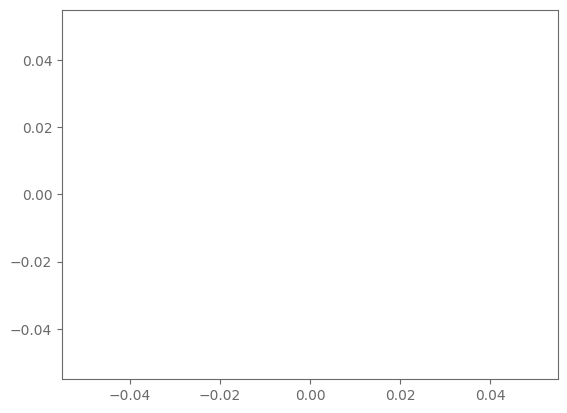

In [11]:
def test_model():
    with torch.no_grad():
        out = model(torch.ones((1, 34))*0.5).reshape(2, -1)
        hists = model.standardizer.destandardize(out)
        print(out)
        plt.plot(hists)
test_model()


In [ ]:
h5_files = list(glob.iglob('datasets/metrix_simulation/ray_emergency_surrogate/data_raw_*.h5'))

load_len = None

dataset = RayDataset(h5_files=h5_files,
                        sub_groups=['1e5/params',
                                    '1e5/ray_output/ImagePlane/histogram', '1e5/ray_output/ImagePlane/n_rays'], transform=Select(keys=['1e5/params', '1e5/ray_output/ImagePlane/histogram', '1e5/ray_output/ImagePlane/n_rays'], search_space=params(), non_dict_transform={'1e5/ray_output/ImagePlane/histogram': StandardizeXYHist()}))

memory_dataset = MemoryDataset(dataset=dataset, load_len=load_len)#, min_n_rays=500)

In [ ]:


load_len: int | None = 10000
dataset_normalize_outputs = True
h5_files = list(glob.iglob('datasets/metrix_simulation/ray_emergency_surrogate/data_raw_*.h5')) # ['datasets/metrix_simulation/ray_emergency_surrogate/49+50_data_raw_0.h5']
dataset = RayDataset(h5_files=h5_files,
                        sub_groups=['1e5/params',
                                    '1e5/ray_output/ImagePlane/histogram', '1e5/ray_output/ImagePlane/n_rays'], transform=Select(keys=['1e5/params', '1e5/ray_output/ImagePlane/histogram', '1e5/ray_output/ImagePlane/n_rays'], search_space=params(), non_dict_transform={'1e5/ray_output/ImagePlane/histogram': StandardizeXYHist()}))


bal_memory_dataset = BalancedMemoryDataset(dataset=dataset, load_len=load_len, min_n_rays=500)
datamodule = DefaultDataModule(dataset=balmemory_dataset, num_workers=4)
datamodule.prepare_data()
model = MetrixXYHistSurrogate(dataset_length=load_len, dataset_normalize_outputs=dataset_normalize_outputs)
wandb_logger = WandbLogger(name="ref_bal_500_sch_.999_test", project="xy_hist", save_dir='outputs')
#wandb_logger = None
datamodule.setup(stage="test")

lr_monitor = LearningRateMonitor(logging_interval='step')
trainer = L.Trainer(max_epochs=10000, logger=wandb_logger, log_every_n_steps=100, check_val_every_n_epoch=1, callbacks=[lr_monitor])
trainer.init_module()

#trainer.test(datamodule=datamodule, ckpt_path='outputs/xy_hist/50f8si6i/checkpoints/epoch=29-step=5842830.ckpt', model=model)

In [ ]:
test_dl = datamodule.test_dataloader()

In [ ]:
# 1. load data & normalize

param_container = params()
param_container = RayParameterContainer({label: NumericalParameter((entry.value_lims[1]-entry.value_lims[0]) / 2 + entry.value_lims[0]) if isinstance(entry, MutableParameter) else entry for label, entry in param_container.items()})
#normalized_param_container = Plot.normalize_parameters(param_container, params())

In [ ]:

engine = RayEngine(rml_basefile='rml_src/METRIX_U41_G1_H1_318eV_PS_MLearn_1.15.rml',
                                exported_planes=["ImagePlane"],
                                ray_backend=RayBackendDockerRAYUI(docker_image='ray-ui-service',
                                                                  docker_container_name='ray-ui-service-test',
                                                                  dockerfile_path='ray_docker/rayui',
                                                                  ray_workdir='/dev/shm/ray-workdir',
                                                                  verbose=False),
                                num_workers=-1,
                                as_generator=False)

In [ ]:
%matplotlib inline

surrogate_engine = HistSurrogateEngine()



#Plot.plot_engines_comparison(engine, surrogate_engine, [param_container for _ in range(2)], MultiLayer([0.]))

In [ ]:

with open("observed_params.pkl", "rb") as f:
    observed_params = pickle.load(f, fix_imports=True, encoding='ASCII', errors='strict', buffers=None)

In [ ]:
from ray_tools.base.parameter import OutputParameter, NumericalParameter
#for param_container in observed_params:
#    for label, param in param_container.items():
#        if isinstance(param, OutputParameter):
#            if isinstance(param_container[label], NumericalParameter):
#                del(param_container[label])#.value = 0.

In [ ]:
for param_container in observed_params:
    for label in ['ImagePlane.translationXerror', 'ImagePlane.translationYerror', 'ImagePlane.translationZerror']:
        if label in list(param_container.keys()):
            del param_container[label]

In [ ]:
Plot.plot_engines_comparison(engine, surrogate_engine, observed_params[:1], MultiLayer([0.]), )
mse_comparison, x_simulation_hist, y_simulation_hist = mse_engines_comparison(engine, surrogate_engine, [observed_params[0]], MultiLayer([0.]))

In [ ]:
torch.cat([x_simulation_hist[0], y_simulation_hist[0]])

In [ ]:
def tensor_to_param_container(ten):
    param_dict = {}
    for i, (label, entry) in enumerate(params().items()):
        if label == 'U41_318eV.numberRays':
            param_dict[label] = entry
        else:
            value = ten[i-1]*(entry.value_lims[1]-entry.value_lims[0])+entry.value_lims[0]
            #print(i-1, label, value)
            param_dict[label] = NumericalParameter(value.item())
            if value.item() < entry.value_lims[0] or value.item() > entry.value_lims[1]:
                if value.item() < entry.value_lims[0]:
                    value = torch.ones_like(value) * entry.value_lims[0]
                elif value.item() > entry.value_lims[1]:
                    value = torch.ones_like(value) * entry.value_lims[1]
                #raise Exception("Out of range. Minimum was {}, maximum {} but value {}. Tensor value was {}.".format(entry.value_lims[0], entry.value_lims[1], value.item(), ten[i-1].item()))
    return RayParameterContainer(param_dict)

In [ ]:
for i in tqdm.tqdm(memory_dataset):#test_dl:
    i = list(i)
    i[1] = i[1].unsqueeze(0)
    if (i[1].sum(dim=0) <.5).all():
        continue
    else:
        biggest = i[1].sum(dim=0).sum(dim=0).flatten().argmax()
        #biggest = i[1].sum(dim=0)#.argmax(dim=0)
        #print(i[0][biggest])
        output = i[0][biggest]
        output_label=i[1][biggest]
        #print(i[0].shape)
        paramz_container = tensor_to_param_container(output)
        #print(output_label.shape)
        print(paramz_container)
        break
    #plt.clf()
    #print(i[0])
    #plt.plot(model(torch.ones([1,34])*0.5)[0].detach().numpy())
    #plt.plot(i[1][0].flatten())
    #plt.show()
    #time.sleep(1)

#Plot.plot_engines_comparison(engine, surrogate_engine, [param_container], MultiLayer([0.]), label)

In [ ]:
from operator import itemgetter
index, element = max(enumerate([entry[2] for entry in memory_dataset]), key=itemgetter(1))


In [ ]:
good_indices = [i for i, entry in enumerate(memory_dataset) if entry[2] > 1000.]
std_backward = surrogate_engine.model.standardizer.destandardize
for i in tqdm.tqdm(good_indices[:20]):
    print(memory_dataset[i][1].squeeze(-1).shape)
    paramz_container = tensor_to_param_container(memory_dataset[i][0])
    fig = Plot.plot_engines_comparison(engine, surrogate_engine, [paramz_container], MultiLayer([0.]), dataset_label=std_backward(memory_dataset[i][1].squeeze(-1)))
    fig.savefig('engines_'+str(i)+'.png')

In [ ]:
nums = [int(entry[2].item()) for entry in memory_dataset if entry[2] != 0]

In [ ]:
plt.hist(nums, bins=100)

In [ ]:
from datasets.metrix_simulation.config_ray_emergency_surrogate import PARAM_CONTAINER_FUNC as params
from tqdm import trange
test_parameters = memory_dataset[850][0]
param_container_list = [tensor_to_param_container(test_parameters)]
fig, ax = plt.subplots(1,2, sharey=True, squeeze=False)
for i in trange(20):
    out = engine.run(param_container_list, MultiLayer([0.]))
    out_simulation = out[-1]['ray_output']['ImagePlane']['0.0']
    x_simulation_hist, _ = torch.histogram(out_simulation.x_loc,bins=50, range=[-10, 10])
    y_simulation_hist, _ = torch.histogram(out_simulation.y_loc,bins=50, range=[-3, 3])
    ax[0, 0].plot(torch.linspace(-10, 10, 50), x_simulation_hist)
    ax[0, 1].plot(torch.linspace(-3, 3, 50), y_simulation_hist)
    break
fig.savefig('check_engine_2.png')

In [ ]:
import pandas as pd
params_list = []
num_rays_list = []
for i in tqdm.tqdm(memory_dataset):
    params_list.append(i[0])
    num_rays_list.append(i[2])
params_tensor = torch.vstack(params_list)
num_rays_tensor= torch.vstack(num_rays_list)

In [ ]:
num_rays_tensor.shape

In [ ]:


# Assuming your tensors are named data_tensor and class_tensor
# Example:
mask = num_rays_tensor > 100.
data_tensor = params_tensor#[mask.flatten()]
data_tensor = data_tensor[:,:4]
class_tensor = num_rays_tensor#[mask]

# Convert the tensors to NumPy arrays
data_np = data_tensor.numpy()
class_np = class_tensor.numpy().flatten()  # Flatten to shape (10000,)

# Fit and transform the data using UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_embedding = umap_model.fit_transform(data_np)

# Plot the UMAP projection
plt.figure(figsize=(12, 8))
scatter = plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=class_np, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title('UMAP projection of the dataset')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [ ]:


#pca = PCA(n_components=5, random_state=42)
#data_np_pca = pca.fit_transform(data_np)

# Fit and transform the data using t-SNE
tsne_model = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
tsne_embedding = tsne_model.fit_transform(data_np)



# Plot the t-SNE projection
plt.figure(figsize=(12, 8))
scatter = plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=class_np, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title('t-SNE projection of the dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

In [ ]:
tensor_to_param_container(torch.randn((34,)))

In [ ]:
test_parameters.shape
torch.rand(34,).min()

In [ ]:
x_loc_list = []
good_param_list = []
batch_size = 5000
for i in trange(15000//batch_size):
    param_container = [tensor_to_param_container(torch.rand((34,))*0.6+0.2) for _ in range(batch_size)]
    surrogate_out = surrogate_engine.run(param_container, MultiLayer([0.]))
    for j in range(len(param_container)):
        output = surrogate_out[j]['ray_output']['ImagePlane']['xy_hist']
        if output.x_loc.sum() > 0.5:
            x_loc_list.append(output.x_loc.sum())
            good_param_list.append(param_container[j])

In [ ]:
plt.hist(x_loc_list)
print(len(good_param_list))

In [ ]:
Plot.plot_engines_comparison(engine, surrogate_engine, [good_param_list[54]], MultiLayer([0.]))


In [ ]:
observed_containers_tensor = torch.vstack([surrogate_engine.select({"1e5/params":param_container})[0] for param_container in observed_params])
good_containers_tensor = torch.vstack([surrogate_engine.select({"1e5/params":param_container})[0] for param_container in good_param_list])

In [ ]:
plt.clf()
for i in range(observed_containers_tensor.shape[0]):
    plt.plot(observed_containers_tensor[i])
    #plt.plot(good_containers_tensor[i])
plt.legend(["observed", "good"])

In [ ]:
plt.clf()
for i in range(good_containers_tensor.shape[0]):
    #plt.plot(observed_containers_tensor[i])
    plt.plot(good_containers_tensor[i])
plt.legend(["observed", "good"])

In [ ]:
def mse_engines_comparison(engine, surrogate_engine, param_container_list: list[RayParameterContainer], transforms):
    out = engine.run(param_container_list, transforms)
    out_surrogate = surrogate_engine.run(param_container_list, transforms)
    std_backward = surrogate_engine.model.standardizer.destandardize
    x_simulation_hist_list = []
    y_simulation_hist_list = []
    mse_list = []
    for i in range(len(out_surrogate)):
        surrogate_hist = out_surrogate[i]['ray_output']['ImagePlane']['xy_hist']
        out_simulation = out[i]['ray_output']['ImagePlane']['0.0']
        x_simulation_hist, _ = torch.histogram(out_simulation.x_loc,bins=50, range=[-10, 10])
        x_simulation_hist_list.append(x_simulation_hist)
        y_simulation_hist, _ = torch.histogram(out_simulation.y_loc,bins=50, range=[-3, 3])
        y_simulation_hist_list.append(y_simulation_hist)
        #print((torch.stack([surrogate_hist.x_loc, surrogate_hist.y_loc])))
        #print(torch.stack([x_simulation_hist, y_simulation_hist]))
        mse = ((torch.stack([std_backward(surrogate_hist.x_loc), std_backward(surrogate_hist.y_loc)]) - torch.stack([x_simulation_hist, y_simulation_hist]))**2).mean()
        mse_list.append(mse)
    return torch.stack(mse_list), x_simulation_hist_list, y_simulation_hist_list

In [ ]:
mse_comparison, x_simulation_hist, y_simulation_hist = mse_engines_comparison(engine, surrogate_engine, good_param_list, MultiLayer([0.]))

In [ ]:
print(x_simulation_hist[0].shape)
plt.clf()
for hist in x_simulation_hist:
    plt.plot(hist, alpha=0.3)
    #plt.ylim([18600,19000])
    #plt.xlim([22.98, 23.02])
#for hist in y_simulation_hist:
#    print(hist.max())
#print(mse_comparison)
#print(y_simulation_hist.shape)

In [ ]:
for i in trange(5):
    out = engine.run(good_param_list[:1], MultiLayer([0.]))
    out_simulation = out[0]['ray_output']['ImagePlane']['0.0']
    x_simulation_hist, _ = torch.histogram(out_simulation.x_loc,bins=50, range=[-10, 10])
    plt.plot(x_simulation_hist)

In [ ]:
plt.hist(mse_comparison)

In [ ]:
mse_comparison.argmax()

In [ ]:
plt.plot(x_simulation_hist[54])

In [21]:
from ray_nn.nn.xy_hist_data_models import StandardizeXYHist
standardizer = StandardizeXYHist(divisor=1., log=True)
a = torch.Tensor([0., 1., 2., 42., 10000.])
st = standardizer(a)
dest = standardizer.destandardize(st)
print(dest)

tensor([0.0000e+00, 1.0000e+00, 2.0000e+00, 4.2000e+01, 1.0000e+04])
